## **Implementación de un modelo de pronóstico para el precio de Bancolombia (CIB) a través de ChatGPT 3.5**

Juan Sebastian Moncada Aguilar

Marketing Analytics

## Carga de librerias

In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Implementación del modelo

In [ ]:
# Definir el ticker de Bancolombia en Yahoo Finance
ticker = "CIB"

# Definir fechas de inicio y fin
end_date = datetime.today().date()
start_date = end_date - timedelta(days=5*365)

# Descargar datos desde Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date, interval="1wk")

# Seleccionar columna "Close" (precio de cierre)
data = data["Close"]

# Crear un DataFrame con fechas y precios
df = pd.DataFrame({'Date': data.index, 'Price': data.values})

# Agregar columnas de características basadas en la fecha
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday

# Preparar datos para el modelo
X = df[['Year', 'Month', 'Day', 'Weekday']].values
y = df['Price'].values

# Crear y entrenar modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Obtener la última fecha en el DataFrame
last_date = df['Date'].iloc[-1]

# Generar fechas para las próximas 4 semanas
forecast_dates = [last_date + timedelta(weeks=i) for i in range(1, 5)]

# Crear datos de características para las fechas de pronóstico
forecast_features = np.array([[date.year, date.month, date.day, date.weekday()] for date in forecast_dates])

# Realizar pronósticos
forecasts = model.predict(forecast_features)

# Crear DataFrame de pronósticos
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecasted Price': forecasts})

print(forecast_df)

[*********************100%%**********************]  1 of 1 completed
        Date  Forecasted Price
0 2023-09-04         24.515818
1 2023-09-11         24.286295
2 2023-09-18         24.056773
3 2023-09-25         23.827250


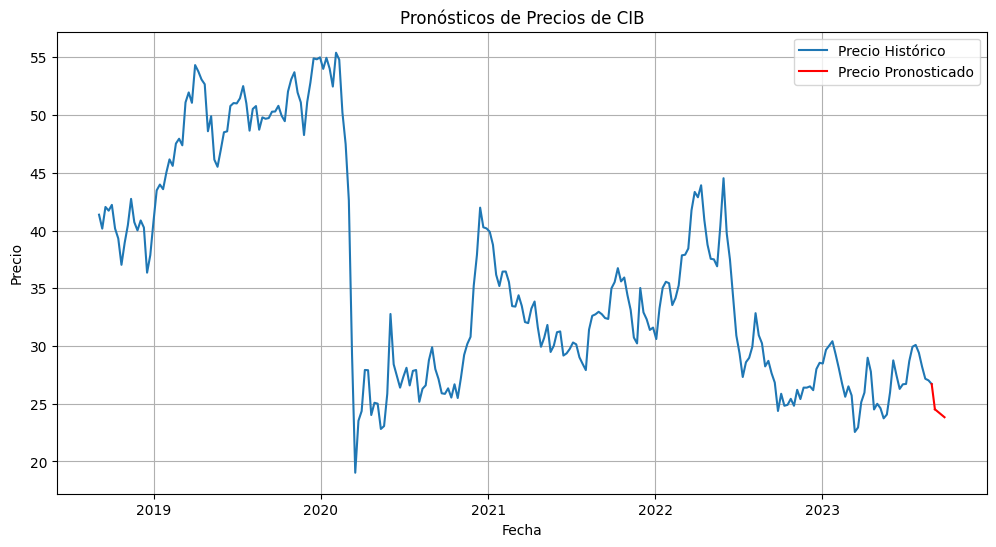

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price'], label='Precio Histórico', linestyle='-')
plt.plot(forecast_df['Date'], forecast_df['Forecasted Price'], label='Precio Pronosticado', linestyle='-', color='red')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.title('Pronósticos de Precios de ' + ticker)
plt.grid(True)

# Unir las líneas de pronóstico con las observaciones reales
plt.plot([df['Date'].iloc[-1], forecast_df['Date'].iloc[0]], [df['Price'].iloc[-1], forecast_df['Forecasted Price'].iloc[0]], linestyle='-', color='red')

# Mostrar el gráfico de pronósticos
plt.legend()
plt.show()

De acuerdo con el gráfico, se observa una alta volatilidad en el precio promedio semanal de Bancolombia, esto es de esperar sabiendo que se trata de una acción transada en bolsa.
Se destaca que el pronostico obtenido del modelo indica que la tendencia a la baja se mantendrá durante las siguientes 4 semanas, llegando a un mínimo de 23.82USD por acción.

# Validación de los resultados del modelo

In [ ]:
model_sm = OLS(y, sm.add_constant(X)).fit()

# Obtener el resumen del modelo
summary = model_sm.summary()

print(summary)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     67.47
Date:                Fri, 01 Sep 2023   Prob (F-statistic):           3.29e-32
Time:                        15:56:15   Log-Likelihood:                -880.43
No. Observations:                 261   AIC:                             1769.
Df Residuals:                     257   BIC:                             1783.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8814.9706    619.387     14.232      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


## Comentarios

- Se observa que el coeficiente de determinación del modelo es de 0.441, lo cual indica que las variables independientes explican en un 44,1% el comportamiento del precio promedio semanal de Bancolombia. Este valor es considerablemente bajo, e indica que el modelo posiblemente no es el más adecuado para el pronostico de precios.
- Las variables Year y Month son estadisticamente significativas con una confianza del 99%. Por otro lado, las variables Day y Weekday no son significativas, es decir, no tienen un efecto sobre el precio de la acción.
No obstante, hay que resaltar que las variables explicativas (Year, Month, Day, Weekday) podrian estar aportando la misma información al modelo, generando problemas de multicolinealidad y por ende resultados inexactos. Incluso al obervar los resultados del modelo, se observa una nota que detalla este problema.
- Se destaca que el valor del estaditico Durbin-Watson es menor a 2, indicando una autocorrelación serial positiva, lo cual indica cierta dependencia entre los errores. Esto implica realizar transformaciones del modelo, pues observaciones de precios del pasado estan afectando al precio actual.

## Análisis del error

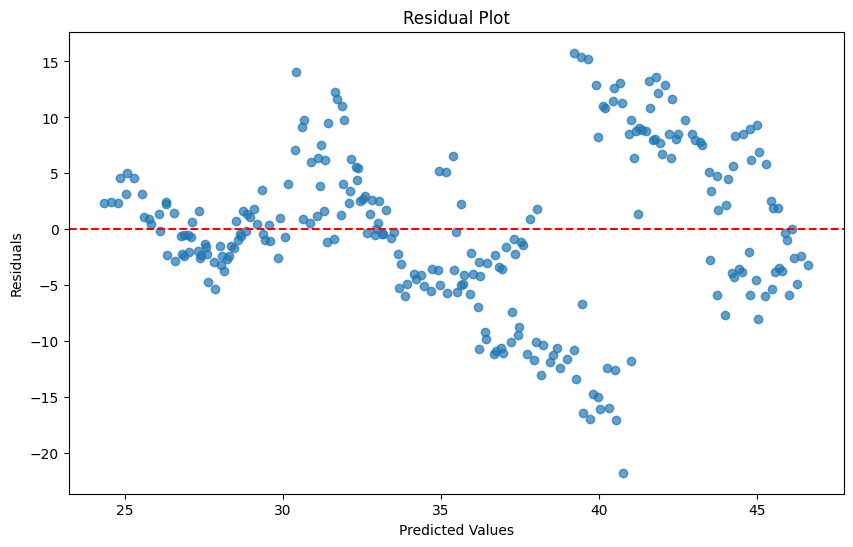

In [ ]:
# Obtener las predicciones del modelo
predictions = model.predict(X)

# Calcular los residuos
residuals = y - predictions

# Crear la gráfica de dispersión de residuos
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

La gráfica de distribución de los residuos resalta una amplia varianza en los residuos, indicando posibles problemas de heterocedasticidad a pesar de que el valor promedio tiende a cero.

## Valor promedio del error

In [ ]:
print(round(np.mean(residuals), 2))

-0.0


Se observa que el valor promedio del error tiende a cero, lo cual es acorde con los supuestos de los modelos de MCO.

## Test de White (detección de heterocedasticidad)

In [ ]:
import statsmodels.stats.api as sms
white_test = sms.het_white(residuals, model_sm.model.exog)

lm_statistic = white_test[0]
lm_p_value = white_test[1]
f_statistic = white_test[2]
f_p_value = white_test[3]

print(f"LM Estadístico: {lm_statistic}")
print(f"P-valor del LM: {lm_p_value}")
print(f"F Estadístico: {f_statistic}")
print(f"P-valor del F: {f_p_value}")

if lm_p_value < 0.05:
    print("Heterocedasticidad detectada: Rechaza la hipótesis nula")
else:
    print("No se detecta heterocedasticidad: No rechaza la hipótesis nula")

LM Estadístico: 59.137739792585656
P-valor del LM: 1.9648641225940722e-09
F Estadístico: 8.170352657900473
P-valor del F: 1.2237426432618652e-10
Heterocedasticidad detectada: Rechaza la hipótesis nula


Los resultados del test de White indican que el error presenta problemas de heterocedasticidad, lo cual indica que este no sigue una distribución normal (media cero y varianza constante).

## Test de multicolinealidad

In [ ]:
X_df = pd.DataFrame(X, columns=['X1', 'X2', 'X3', 'X4'])  # Ajusta los nombres de columna según tus datos

# Calcula el VIF para cada variable independiente
vif = pd.DataFrame()
vif["Variable"] = X_df.columns
vif["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]

print(vif)

  Variable       VIF
0       X1  7.658239
1       X2  4.599299
2       X3  4.207281
3       X4       NaN


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Se observa que los resultados del estadistico VIF para las variables independientes del modelo son mayores a 1, lo cual indica que evidentemente el modelo presenta problemas de multicolinealidad, lo cual puede llevar a sobreestimar los efectos de las variables explicativas.

# Conclusiones

Si bien el modelo es capaz de proporcionar los pronósticos del precio promedio semanal para Bancolombia, los análisis realizados indican que estos pronósticos no son fiables, pues en primer lugar la selección de variables es incorrecta debido a la alta multicolinealidad detectada entre ellas. A partir de allí se detecta una serie de problemas del modelo asociados a la autocorrelación de los errores y heterocedasticidad. El resultado final es un modelo con una significancia global bastante baja (44,1%).

Además, cabe mencionar que la metodología utilizada tampoco es la adecuada, pues las series de tiempo asociadas a las acciones y demás instrumentos del mercado de valores son denominadas como "series explosivas", es decir, que presentan una alta varianza. En consecuencia, la implementación de un modelo ARCH o GARCH, los cuales están diseñados para el pronóstico de series de este tipo, puede llegar a ser más eficiente.


Por último, se destaca que el modelo implementado no fue pre-entrenado, lo cual es una buena práctica en la implementación de modelos con el fin de evitar el sobreajuste.